In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pyproj import CRS
import sys
import os
import pickle
import matplotlib.pyplot as plt
from pyproj import CRS
from shapely import wkt
from shapely.geometry import Polygon, MultiPolygon
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns
from citymob import import_csv_w_wkt_to_gdf
from sklearn.metrics import r2_score


cities=['Berlin','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien']
countries=['Germany','Germany','Germany','Germany','Germany','Germany','Germany','Germany','France','France','France','France','France','France','France','France','France','Spain','Austria']
crs0=3035

In [2]:
pa=pd.read_csv('../../MSCA_data/GermanPopulationPostcode/plz-5stellig-daten.csv')
pa['postcode']=pa['plz'].map(lambda x: str(x).zfill(5))
pa.head()

,plz,note,qkm,einwohner,postcode
0,1067,01067 Dresden,6.866862,11957,01067
1,1069,01069 Dresden,5.351833,25491,01069
2,1097,01097 Dresden,3.297752,14821,01097
3,1099,01099 Dresden,58.506789,28018,01099
4,1108,01108 Dresden,16.447222,5876,01108


In [3]:
# germann postcodes gdf
fp='../shapefiles/plz-5stellig.shp/plz-5stellig.shp'
de_plz = gpd.read_file(fp)
de_plz.to_crs(crs0,inplace=True)
# keep only the desired info from de_plz and pa
de_plz=de_plz.loc[:,('plz','geometry')].merge(pa.drop(columns='plz'),left_on='plz',right_on='postcode')
de_plz['area']=de_plz.area*1e-6
de_plz['Density']=de_plz['einwohner']/de_plz['area']
de_plz.rename(columns={'plz':'geo_unit'},inplace=True)

# load dictionary of city postcodes for Germany
with open('../dictionaries/city_postcode_DE.pkl','rb') as f:
    city_plz = pickle.load(f)


In [4]:
# read in shapefile of user-defined (for now) city centers
centers=import_csv_w_wkt_to_gdf('../source/citycenters/centers.csv',crs=4326)
centers.to_crs(crs0,inplace=True)

In [8]:
# function to plot figures mapping key metrics by postcode (or similar) for all cities
def geom_plot(city):
    print(city)
    country=countries[cities.index(city)]

    if country == 'Germany':
        city_map=de_plz.loc[de_plz['geo_unit'].isin(city_plz[city]),:].copy()
        city_map.loc[:,'city']=city
        city_map.loc[:,'Country']=country
        
        if city == 'Berlin': # for Berlin, first in the loop, initiate the city_map_all df, and set the scaling factor based on Berlin. This will allow plots to be on comparabale scales later.
            global city_map_all
            city_map_all=city_map.copy()
            xex=city_map.total_bounds[2]-city_map.total_bounds[0]
            yex=city_map.total_bounds[3]-city_map.total_bounds[1]
            global scale 
            scale=xex/14

            stats=pd.read_csv('../outputs/Summary_geounits/'+city+'.csv',dtype={'Res_geocode':str})
            stats['Res_geocode']=stats.loc[:,'Res_geocode'].astype('str')
            stats.iloc[:,[1,2,3,4,5,8]]=stats.iloc[:,[1,2,3,4,5,8]]*100 # convert shares to %
            stats.fillna(0,inplace=True)
            city_stats=city_map.merge(stats,how='left',left_on='geo_unit',right_on='Res_geocode')

            # stats_or=pd.read_csv('../outputs/Summary_geounits/'+city+'_modeshare_origin.csv',dtype={'Ori_Plz':str})
            # stats_or=stats_or.add_suffix('_or').copy()
            # stats_or.rename(columns={'Ori_Plz_or':'Ori_Plz'},inplace=True)
            # stats_or.iloc[:,1:6]=stats_or.iloc[:,1:6]*100 # convert shares to %
            # stats_or.fillna(0,inplace=True)
            # city_stats=city_stats.merge(stats_or,how='left',left_on='geo_unit',right_on='Ori_Plz')

            d2c=pd.read_csv('../outputs/CenterSubcenter/Berlin_dist.csv',dtype={'plz':str,'geocode':str})
            if 'plz' in d2c.columns:
                d2c.rename(columns={'plz':'geocode'},inplace=True)
            d2c['geocode']=d2c['geocode'].astype(str)

            city_stats=city_stats.merge(d2c,how='left',left_on='geo_unit',right_on='geocode')

            global city_stats_all
            city_stats_all=city_stats.copy()
        else:
            city_map=de_plz.loc[de_plz['geo_unit'].isin(city_plz[city])].copy()
            city_map.loc[:,'city']=city
            city_map.loc[:,'Country']=country
            city_map_all=pd.concat([city_map_all,city_map])
            xex=city_map.total_bounds[2]-city_map.total_bounds[0]
            yex=city_map.total_bounds[3]-city_map.total_bounds[1]

            stats=pd.read_csv('../outputs/Summary_geounits/'+city+'.csv',dtype={'Res_geocode':str})
            stats['Res_geocode']=stats.loc[:,'Res_geocode'].astype('str')
            stats.iloc[:,[1,2,3,4,5,8]]=stats.iloc[:,[1,2,3,4,5,8]]*100 # convert shares to %
            stats.fillna(0,inplace=True)
            city_stats=city_map.merge(stats,how='left',left_on='geo_unit',right_on='Res_geocode')

            # stats_or=pd.read_csv('../outputs/Summary_geounits/'+city+'_modeshare_origin.csv',dtype={'Ori_Plz':str})
            # stats_or=stats_or.add_suffix('_or').copy()
            # stats_or.rename(columns={'Ori_Plz_or':'Ori_Plz'},inplace=True)
            # stats_or.iloc[:,1:6]=stats_or.iloc[:,1:6]*100
            # stats_or.fillna(0,inplace=True)
            # city_stats=city_stats.merge(stats_or,how='left',left_on='geo_unit',right_on='Ori_Plz')

            d2c=pd.read_csv('../outputs/CenterSubcenter/' + city + '_dist.csv',dtype={'plz':str,'geocode':str})
            if 'plz' in d2c.columns:
                d2c.rename(columns={'plz':'geocode'},inplace=True)
            d2c['geocode']=d2c['geocode'].astype(str)
            city_stats=city_stats.merge(d2c,how='left',left_on='geo_unit',right_on='geocode')
            city_stats_all=pd.concat([city_stats_all,city_stats])

        # if city=='Magdeburg':
        #     #boun=gpd.GeoDataFrame({'geometry':[city_map.loc[city_map['geo_unit']!='39179',].unary_union]},crs=crs0)
        #     uuall=city_map.unary_union
        #     polyb=Polygon(uuall.geoms[0].exterior)
        #     boun=gpd.GeoDataFrame(geometry=[polyb], crs=crs0)
        # else: boun=gpd.GeoDataFrame({'geometry':[city_stats['geometry'].unary_union.exterior]},crs=crs0)

    if country in ['France', 'Spain','Austria']:
        
        if city =='Wien': city_map=import_csv_w_wkt_to_gdf('../outputs/density_geounits/'+city+'_pop_density.csv',crs=crs0,gc='geocode'); city_map.rename(columns={'geocode':'geo_unit'},inplace=True)
        elif city in ['Paris','Madrid']: city_map=import_csv_w_wkt_to_gdf('../outputs/density_geounits/'+city+'_pop_density_lowres.csv',crs=crs0,gc='geocode')
        else: city_map=import_csv_w_wkt_to_gdf('../outputs/density_geounits/'+city+'_pop_density_mixres.csv',crs=crs0,gc='geocode'); city_map.rename(columns={'geocode':'geo_unit'},inplace=True)

        city_map['geo_unit']=city_map.loc[:,'geo_unit'].astype(str)
        city_map.loc[:,'city']=city
        city_map.loc[:,'Country']=country

        city_map_all=pd.concat([city_map_all,city_map])
        xex=city_map.total_bounds[2]-city_map.total_bounds[0]
        yex=city_map.total_bounds[3]-city_map.total_bounds[1]

        # if city in ['Paris','Wien']:  stats=pd.read_csv('../outputs/Summary_geounits/'+city+'.csv'); stats.rename(columns={'Res_geocode':'geo_unit'},inplace=True) #2nd part Paris only
        # else: stats=pd.read_csv('../outputs/Summary_geounits/'+city+'_agg.csv')
        stats=pd.read_csv('../outputs/Summary_geounits/'+city+'.csv',dtype={'Res_geocode':str}); stats.rename(columns={'Res_geocode':'geo_unit'},inplace=True)
        stats['geo_unit']=stats.loc[:,'geo_unit'].astype('str')
        stats.iloc[:,[1,2,3,4,5,8]]=stats.iloc[:,[1,2,3,4,5,8]]*100 # convert shares to %
        stats.fillna(0,inplace=True)
        city_stats=city_map.merge(stats,how='left',left_on='geo_unit',right_on='geo_unit')

        # stats_or=pd.read_csv('../outputs/Summary_geounits/'+city+'_modeshare_origin.csv',dtype={'Ori_geo_unit':str})
        # stats_or=stats_or.add_suffix('_or').copy()
        # stats_or.rename(columns={'Ori_geo_unit_or':'Ori_geo_unit'},inplace=True)
        # stats_or.iloc[:,1:6]=stats_or.iloc[:,1:6]*100
        # stats_or.fillna(0,inplace=True)
        # city_stats=city_stats.merge(stats_or,how='left',left_on='geo_unit',right_on='Ori_geo_unit')

        d2c=pd.read_csv('../outputs/CenterSubcenter/' + city + '_dist.csv',dtype={'plz':str,'geocode':str})
        d2c['geocode']=d2c['geocode'].astype(str)
        city_stats=city_stats.merge(d2c,how='left',left_on='geo_unit',right_on='geocode')
        city_stats_all=pd.concat([city_stats_all,city_stats])
    
        # if city in ['Dijon','Lille','Madrid']:
        # #boun=gpd.GeoDataFrame({'geometry':[city_map.unary_union]},crs=crs0)
        #     uuall=city_map.unary_union
        #     polyb=Polygon(uuall.geoms[0].exterior)
        #     boun=gpd.GeoDataFrame(geometry=[polyb], crs=crs0)
        # else: boun=gpd.GeoDataFrame({'geometry':[city_stats['geometry'].unary_union.exterior]},crs=crs0)
        # #boun=gpd.GeoDataFrame({'geometry':[city_map.unary_union]},crs=crs0)

    # from here on code is identical for all cities
    city_center=centers.loc[centers['City']==city,].copy()
    city_center_buffer=city_center.copy()
    city_center_buffer['geometry']=city_center_buffer['geometry'].buffer(8000)  

    print('Finished gathering stats for ' + city)

cities_all=pd.Series(['Berlin','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse', 'Madrid','Wien'])
cities_all.apply(geom_plot)

# now make summary figures and models of key variables from all cities
city_stats_df=pd.DataFrame(city_stats_all.drop(columns='geometry'))
df=city_stats_df.dropna(subset=('Daily_Distance_Person_Car','Density','Distance2Center','Share_Distance_Car')).copy()
df=df.loc[:,('Country','city' ,'Daily_Distance_Person_Car','Density','Distance2Center','Share_Distance_Car')]
df=df.loc[df['Daily_Distance_Person_Car']>0,:]
df.reset_index(drop=True,inplace=True)
# this is an alternative if we don't omit rows with non-zero car travel
# df.loc[:,'Daily_Distance_Person_Car']=df.loc[:,'Daily_Distance_Person_Car'].replace(0,0.5)
# df.loc[:,'Share_Distance_Car']=df.loc[:,'Share_Distance_Car'].replace(0,0.5)

df['Region']=df['city'].copy()
df.loc[(df['Country']=='France') & (df['city']!='Paris'),'Region']='FR_Other'
df.loc[(df['Country']=='Germany') & (df['city']!='Berlin'),'Region']='DE_Other'
regions=df['Region'].unique()

labs={'Daily_Distance_Person_Car':'Distance by Car (km/cap/day)','Density':'Density (per/km2)', 'Distance2Center':'Distance to Center (km)','Share_Distance_Car':'Mode Share by Car (%)'}


Berlin
Finished gathering stats for Berlin
Dresden
Finished gathering stats for Dresden
Düsseldorf
Finished gathering stats for Düsseldorf
Frankfurt am Main
Finished gathering stats for Frankfurt am Main
Kassel
Finished gathering stats for Kassel
Leipzig
Finished gathering stats for Leipzig
Magdeburg
Finished gathering stats for Magdeburg
Potsdam
Finished gathering stats for Potsdam
Clermont
Finished gathering stats for Clermont
Dijon
Finished gathering stats for Dijon
Lille
Finished gathering stats for Lille
Lyon
Finished gathering stats for Lyon
Montpellier
Finished gathering stats for Montpellier
Nantes
Finished gathering stats for Nantes
Nimes
Finished gathering stats for Nimes
Paris
Finished gathering stats for Paris
Toulouse
Finished gathering stats for Toulouse
Madrid
Finished gathering stats for Madrid
Wien
Finished gathering stats for Wien


In [ ]:
# # first version
# def plot_all(variables,rel,title):
#     y=variables.split('*')[0]
#     x=variables.split('*')[1]
#     n=100
#     x_fitted = np.linspace(np.min(df[x]), np.max(df[x]), n)
#     xy=pd.DataFrame(columns = ['Region','x_fit','y_fit','R2','Slope/Beta'])

#     for r in regions:
#         x_r=df.loc[df['Region']==r,x]
#         y_r=df.loc[df['Region']==r,y]

#         if rel=='lin':
#             z_r = np.polyfit(x_r, y_r, 1)
#             p_r = np.poly1d(z_r)
#             y_r_fit=p_r(x_fitted)
#             r2_r=r2_score(y_r, p_r(x_r))
#             Slope=z_r[0]
#             xy_r=pd.DataFrame({'Region':r,'x_fit':x_fitted,'y_fit':y_r_fit,'R2':r2_r,'Slope/Beta':Slope})

#             #xy=pd.concat([xy,xy_r])

#         if rel=='exp':
#             # exp fit
#             a_r=np.exp(np.polyfit(x_r, np.log(y_r), 1)[1])
#             b_r=np.polyfit(x_r, np.log(y_r), 1)[0]
#             y_r_fit=a_r * np.exp(b_r * x_fitted)

#             r2_r=r2_score(y_r, a_r * np.exp(b_r * x_r))
#             Slope=b_r
#             xy_r=pd.DataFrame({'Region':r,'x_fit':x_fitted,'y_fit':y_r_fit,'R2':r2_r,'Slope/Beta':Slope})

#     xy=pd.concat([xy,xy_r])
#     xy.reset_index(drop=True,inplace=True)
#     xy['Region_R2']=xy['Region'] + ' (' + xy['R2'].map(lambda x: round(x,2)).astype(str) + ')'

#     fig, ax = plt.subplots(figsize=(8,6))
#     sns.scatterplot(ax=ax,x=x, y=y, data=df, hue='Region',alpha=0.4,s=50,legend=False)
#     sns.lineplot(x='x_fit', y='y_fit', data=xy, hue='Region',alpha=0.99)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

#     plt.title(title,fontsize=18)
#     plt.xlabel(labs[x],fontsize=16)
#     plt.ylabel(labs[y],fontsize=16)#
#     plt.xticks(fontsize=14);
#     plt.yticks(fontsize=14);

#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 1.0),fontsize=12)
#     plt.show()
#     #plt.savefig('../figures/summary_all/' + title + '_' + rel + '.png',facecolor='w',dpi=65,bbox_inches='tight')

#     print('R2:')
#     print(round(xy.groupby('Region')['R2'].mean(),3))
#     print('Slopes:')
#     print(round(xy.groupby('Region')['Slope/Beta'].mean(),6))

#     ret = pd.DataFrame(xy.groupby('Region')['R2'].mean()).reset_index().merge(pd.DataFrame(xy.groupby('Region')['Slope/Beta'].mean()).reset_index())
#     ret['Relationship']=title
#     ret['Model']=rel

#     return ret

In [9]:
# second version
def plot_all(variables,rel,title):
    y=variables.split('*')[0]
    x=variables.split('*')[1]
    n=100
    x_fitted = np.linspace(np.min(df[x]), np.max(df[x]), n)
    xy=pd.DataFrame(columns = ['Region','x_fit','y_fit','R2','Slope/Beta'])

    for r in regions:
        x_r=df.loc[df['Region']==r,x]
        y_r=df.loc[df['Region']==r,y]

        if rel=='lin':
            z_r = np.polyfit(x_r, y_r, 1)
            p_r = np.poly1d(z_r)
            y_r_fit=p_r(x_fitted)
            r2_r=r2_score(y_r, p_r(x_r))
            Slope=z_r[0]
            xy_r=pd.DataFrame({'Region':r,'x_fit':x_fitted,'y_fit':y_r_fit,'R2':r2_r,'Slope/Beta':Slope})

            xy=pd.concat([xy,xy_r])

        if rel=='exp':
            # exp fit
            a_r=np.exp(np.polyfit(x_r, np.log(y_r), 1)[1])
            b_r=np.polyfit(x_r, np.log(y_r), 1)[0]
            y_r_fit=a_r * np.exp(b_r * x_fitted)

            r2_r=r2_score(y_r, a_r * np.exp(b_r * x_r))
            Slope=b_r
            xy_r=pd.DataFrame({'Region':r,'x_fit':x_fitted,'y_fit':y_r_fit,'R2':r2_r,'Slope/Beta':Slope})

            xy=pd.concat([xy,xy_r])
    xy.reset_index(drop=True,inplace=True)
    xy['Region_R2']=xy['Region'] + ' (' + xy['R2'].map(lambda x: round(x,2)).astype(str) + ')'

    fig, ax = plt.subplots(figsize=(8,6))
    sns.scatterplot(ax=ax,x=x, y=y, data=df, hue='Region',alpha=0.5,s=30,legend=False)
    sns.lineplot(x='x_fit', y='y_fit', data=xy, hue='Region_R2',alpha=1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    plt.title(title,fontsize=18)
    plt.xlabel(labs[x],fontsize=16)
    plt.ylabel(labs[y],fontsize=16)#
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 1.0),fontsize=12)
    plt.show()
    #plt.savefig('../figures/summary_all/' + title + '_' + rel + '_new.png',facecolor='w',dpi=65,bbox_inches='tight')

    print('R2:')
    print(round(xy.groupby('Region')['R2'].mean(),3))
    print('Slopes:')
    print(round(xy.groupby('Region')['Slope/Beta'].mean(),6))

    ret = pd.DataFrame(xy.groupby('Region')['R2'].mean()).reset_index().merge(pd.DataFrame(xy.groupby('Region')['Slope/Beta'].mean()).reset_index())
    ret['Relationship']=title
    ret['Model']=rel

    return ret

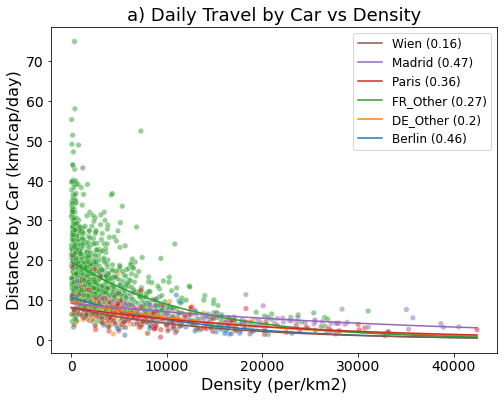

R2:
Region
Berlin      0.459
DE_Other    0.197
FR_Other    0.274
Madrid      0.468
Paris       0.363
Wien        0.162
Name: R2, dtype: float64
Slopes:
Region
Berlin     -0.000074
DE_Other   -0.000054
FR_Other   -0.000079
Madrid     -0.000026
Paris      -0.000045
Wien       -0.000067
Name: Slope/Beta, dtype: float64


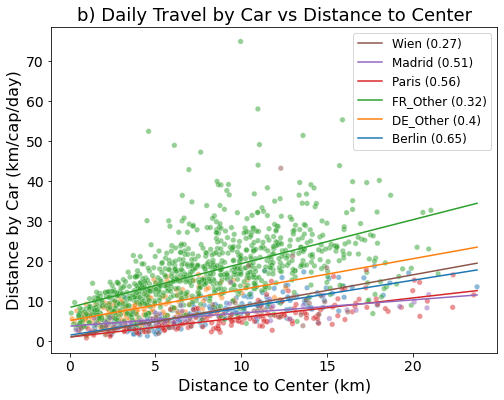

R2:
Region
Berlin      0.652
DE_Other    0.398
FR_Other    0.323
Madrid      0.512
Paris       0.555
Wien        0.272
Name: R2, dtype: float64
Slopes:
Region
Berlin      0.687790
DE_Other    0.773702
FR_Other    1.098756
Madrid      0.329458
Paris       0.490248
Wien        0.779950
Name: Slope/Beta, dtype: float64


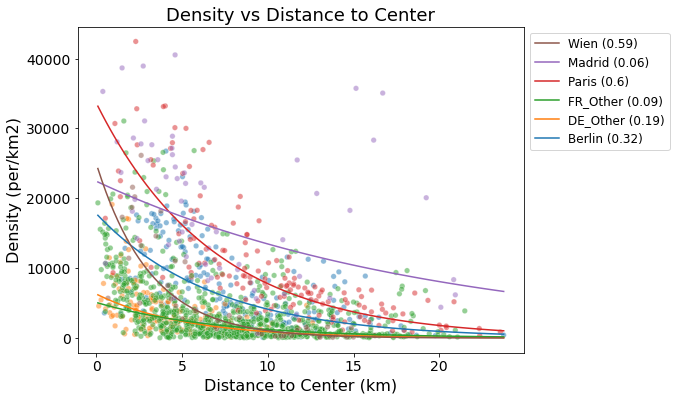

R2:
Region
Berlin      0.318
DE_Other    0.192
FR_Other    0.095
Madrid      0.064
Paris       0.605
Wien        0.590
Name: R2, dtype: float64
Slopes:
Region
Berlin     -0.146088
DE_Other   -0.192777
FR_Other   -0.142264
Madrid     -0.051071
Paris      -0.146276
Wien       -0.315439
Name: Slope/Beta, dtype: float64


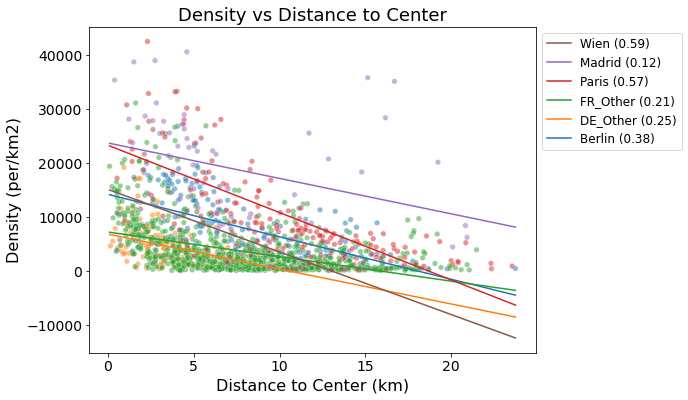

R2:
Region
Berlin      0.384
DE_Other    0.247
FR_Other    0.212
Madrid      0.120
Paris       0.573
Wien        0.590
Name: R2, dtype: float64
Slopes:
Region
Berlin      -785.250001
DE_Other    -645.941053
FR_Other    -454.517725
Madrid      -655.358160
Paris      -1245.952694
Wien       -1157.729607
Name: Slope/Beta, dtype: float64


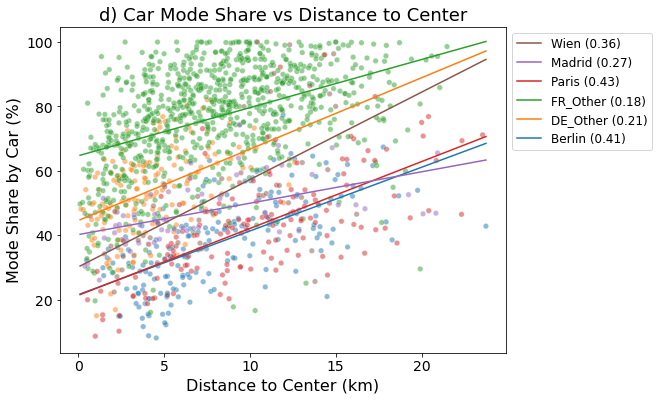

R2:
Region
Berlin      0.409
DE_Other    0.210
FR_Other    0.180
Madrid      0.269
Paris       0.429
Wien        0.361
Name: R2, dtype: float64
Slopes:
Region
Berlin      1.976350
DE_Other    2.213728
FR_Other    1.492712
Madrid      0.973975
Paris       2.073081
Wien        2.710183
Name: Slope/Beta, dtype: float64


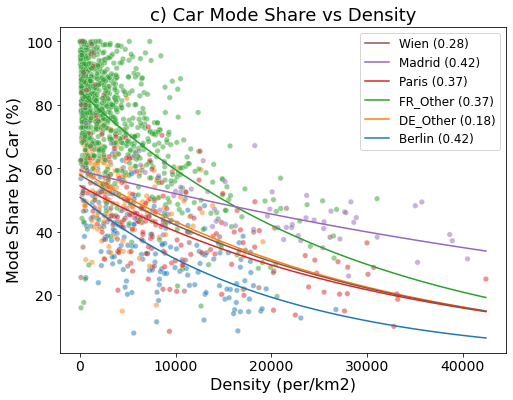

R2:
Region
Berlin      0.423
DE_Other    0.175
FR_Other    0.372
Madrid      0.416
Paris       0.370
Wien        0.285
Name: R2, dtype: float64
Slopes:
Region
Berlin     -0.000048
DE_Other   -0.000032
FR_Other   -0.000035
Madrid     -0.000013
Paris      -0.000031
Wien       -0.000032
Name: Slope/Beta, dtype: float64


In [10]:
car_dist_vs_density_exp=plot_all('Daily_Distance_Person_Car*Density','exp','a) Daily Travel by Car vs Density')
car_dist_vs_dist2cent_lin=plot_all('Daily_Distance_Person_Car*Distance2Center','lin','b) Daily Travel by Car vs Distance to Center')
density_vs_dist2cent_exp=plot_all('Density*Distance2Center','exp','Density vs Distance to Center')
density_vs_dist2cent_lin=plot_all('Density*Distance2Center','lin','Density vs Distance to Center')
car_share_vs_dist2cent_lin=plot_all('Share_Distance_Car*Distance2Center','lin','d) Car Mode Share vs Distance to Center')
car_share_vs_density_exp=plot_all('Share_Distance_Car*Density','exp','c) Car Mode Share vs Density')